In [1]:
# Import the necessary libraries
import os
import sys

SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat, savemat
import control as ct
from control.matlab import tf, ss, lsim, bode, c2d
from scipy.io import loadmat, savemat
from utils.ce_drive_get_params import isstable, simulate_model
from utils.ce_drive_data_utils import generate_trajectory, generate_trajectory_param_pairs_ce_drive, generate_normal
from utils.plot_utils import plot_trajectories
import json
import torch
from torch import nn
from torch.autograd import Variable
from src.rnn_models_ce_drive import RNN_model, push_model

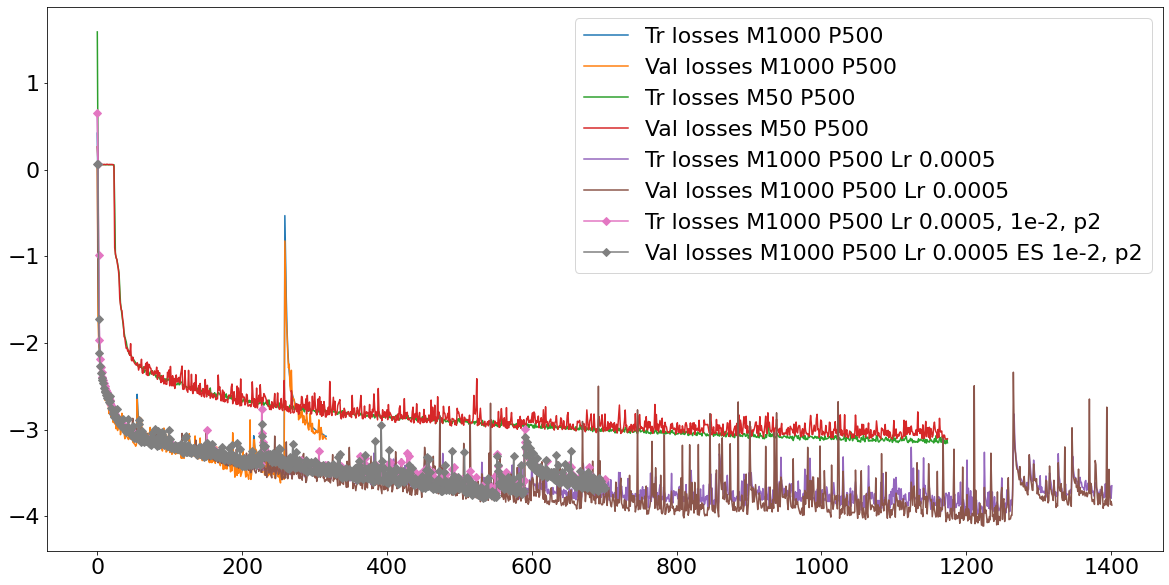

In [2]:
with open('../log/ce_drive/prbs/gru_L2_H40_results_25122021_140801/gru_losses_eps3000.json') as p:
    plot_data_1 = json.load(p)

with open('../log/ce_drive/prbs/gru_L2_H40_results_05122021_120104/gru_losses_eps4000.json') as p:
    plot_data_2 = json.load(p)

with open('../log/ce_drive/prbs/gru_L2_H40_results_26122021_001118/gru_losses_eps3000.json') as p:
    plot_data_3 = json.load(p)

with open('../log/ce_drive/prbs/gru_L2_H40_results_29122021_182711/gru_losses_eps3000.json') as p:
    plot_data_4 = json.load(p)

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot(np.log10(plot_data_1['tr_losses']))
plt.plot(np.log10(plot_data_1['val_losses']))
plt.plot(np.log10(plot_data_2['tr_losses']))
plt.plot(np.log10(plot_data_2['val_losses']))
plt.plot(np.log10(plot_data_3['tr_losses']))
plt.plot(np.log10(plot_data_3['val_losses']))
plt.plot(np.log10(plot_data_4['tr_losses']), '-D')
plt.plot(np.log10(plot_data_4['val_losses']), '-D')
plt.legend(['Tr losses M1000 P500', 'Val losses M1000 P500', 'Tr losses M50 P500', 'Val losses M50 P500', \
            'Tr losses M1000 P500 Lr 0.0005', 'Val losses M1000 P500 Lr 0.0005', \
            'Tr losses M1000 P500 Lr 0.0005, 1e-2, p2', 'Val losses M1000 P500 Lr 0.0005 ES 1e-2, p2'])
plt.show()

In [3]:
# Import dataset
data_prbs_signal = loadmat('../data/coupled_drive/DATAPRBS.MAT')
data_uniform_signal = loadmat('../data/coupled_drive/DATAUNIF.MAT')

In [4]:
z1, z2, z3 = data_prbs_signal['z1'], data_prbs_signal['z2'], data_prbs_signal['z3']
u1, u2, u3 = data_prbs_signal['u1'], data_prbs_signal['u2'], data_prbs_signal['u3']

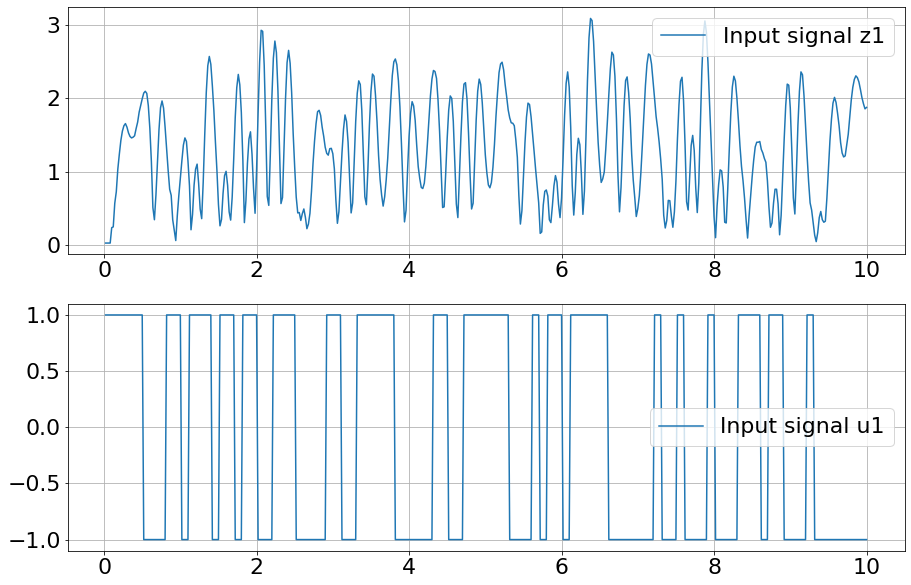

In [5]:
# Plot one of the datasets
Ts = 20e-3
N = 500
t = np.linspace(1, N, N)
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 22})
plt.subplot(211)
plt.plot(t*Ts, z1, label='Input signal z1')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(t*Ts, u1, label='Input signal u1')
plt.grid()
plt.legend()
plt.show()

In [6]:
# Possible model - 1 (table 3, second row)
a = 5163
b = -19.93
c = -509.8
d = -2835

In [7]:
s = tf('s')
G = a/(s**3 -b*s**2 - c*s -d)

In [8]:
# Getting the parameters
poles = np.roots(np.array([1, 19.93, 509.8, 2835]))
real_poles = (np.real(poles[np.isreal(poles)])).item()
k = -a/d
alpha = -real_poles
omega0 = np.sqrt(-d/alpha)
xi = (-b - alpha)/(2*omega0)

In [9]:
# Make the transfer function H(s)
Hs = (k*alpha*omega0**2)/((s+alpha)*(s**2 + 2*xi*omega0*s + omega0**2))
print(Hs)


              5163
--------------------------------
s^3 + 19.93 s^2 + 509.8 s + 2835



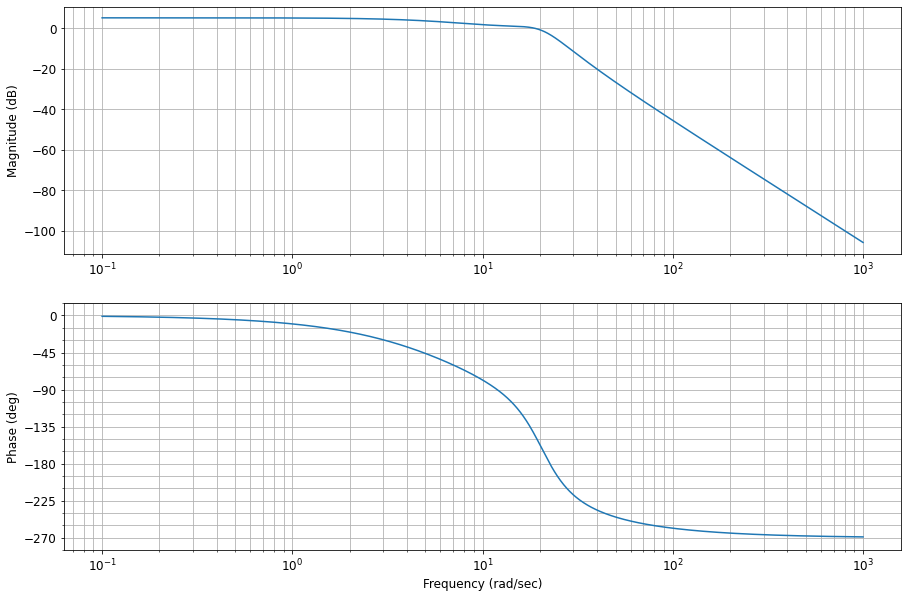

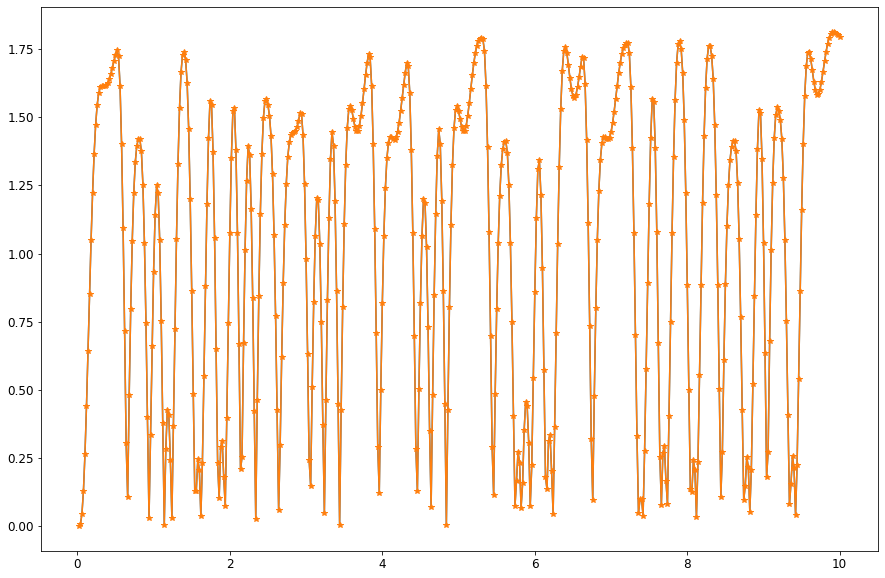

In [10]:
# Simulate the model Gs
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 12})
bode(G)
plt.show()
plt.figure(figsize=(15, 10))
y_model, T, xout = lsim(sys=ss(G), U=u1, T=np.linspace(1,500,500)*Ts)
y_model = np.abs(y_model)
plt.plot(t*Ts, y_model)
plt.plot(t*Ts, np.abs(y_model), '-*')
plt.show()

y_model = np.abs(y_model)

In [11]:
help(lsim)

Help on function lsim in module control.matlab.timeresp:

lsim(sys, U=0.0, T=None, X0=0.0)
    Simulate the output of a linear system.
    
    As a convenience for parameters `U`, `X0`:
    Numbers (scalars) are converted to constant arrays with the correct shape.
    The correct shape is inferred from arguments `sys` and `T`.
    
    Parameters
    ----------
    sys: LTI (StateSpace, or TransferFunction)
        LTI system to simulate
    
    U: array-like or number, optional
        Input array giving input at each time `T` (default = 0).
    
        If `U` is ``None`` or ``0``, a special algorithm is used. This special
        algorithm is faster than the general algorithm, which is used otherwise.
    
    T: array-like, optional for discrete LTI `sys`
        Time steps at which the input is defined; values must be evenly spaced.
    
    X0: array-like or number, optional
        Initial condition (default = 0).
    
    Returns
    -------
    yout: array
        Response o

[[ 0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00]
 [-2.835e+03 -5.098e+02 -1.993e+01]] [[   0]
 [   0]
 [5163]] [1 0 0]
(500,)


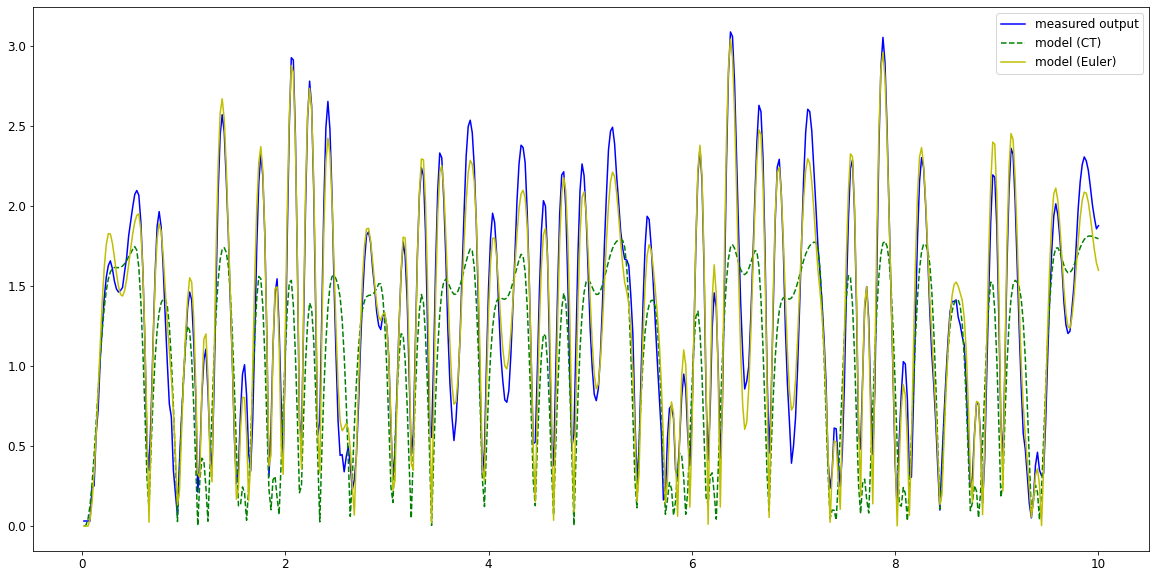

In [12]:
# simulation with euler discretization
A = np.array([[0,1,0],
              [0,0,1],
              [d,c,b]])

B = np.array([[0], [0], [a]])
C = np.array([1, 0, 0])
print(A, B, C)
A_euler = np.eye(3) + Ts*A;
B_euler = Ts*B;
C_euler = C;

# construct Euler discretized state space 
model_euler = ss(A_euler, B_euler, C_euler, 0, 1)
print(lsim(model_euler, u1.reshape((-1,)))[0].shape)
y_model_euler = np.abs(lsim(model_euler, u1.reshape((-1,)))[0]);
plt.figure(figsize=(20,10))
#plt.subplot(2,1,1)
plt.plot(t*Ts, z1,'b')
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
plt.plot(t*Ts, y_model,'g--')
plt.plot(t*Ts, y_model_euler,'y')
plt.legend(['measured output','model (CT)', 'model (Euler)'])

In [13]:
def plot_input_dataset(Ts, N, input_signal, output_signal):
    
    # Plot one of the datasets
    t = np.linspace(1, N, N)
    plt.figure(figsize=(15, 10))
    plt.rcParams.update({'font.size': 22})
    plt.subplot(211)
    plt.plot(t*Ts, output_signal, label='Input signal')
    plt.grid()
    plt.legend()
    plt.subplot(212)
    plt.plot(t*Ts, input_signal, label='Input signal')
    plt.grid()
    plt.legend()
    plt.show()

def compute_model_tf(a, b, c, d):
    
    s = tf('s')
    Gs = a/(s**3 -b*s**2 - c*s -d)
    return Gs

def get_poles(b, c, d):
    
    poles = np.roots(np.array([1, -b, -c, -d]))
    alpha = (np.real(poles[np.isreal(poles)])).item()
    return alpha, poles

def compute_actual_parameters(a, b, c, d, alpha):
    
    # Getting the parameters
    k = -a/d
    alpha = -alpha
    omega0 = np.sqrt(-d/alpha)
    xi = (-b - alpha)/(2*omega0)
    return k, alpha, omega0, xi

def compute_actual_tf(k, alpha, omega0, xi):
    
    s = tf('s')
    Hs = (k*alpha*omega0**2)/((s+alpha)*(s**2 + 2*xi*omega0*s + omega0**2))
    return Hs

def simulate_bode(G):
    
    # Simulate the model Gs's bode plot
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 12})
    bode(G)
    plt.show()
    
def simulate_model(Gs, u, t_arr=None):
    
    # Simulate output of a linear system
    if t_arr is None:
        y_model = lsim(sys=Gs, U=u)[0]
    else:
        y_model, T, xout = lsim(sys=ss(Gs), U=u, T=t_arr)
   
    y_model = np.abs(y_model)
    return y_model

def euler_discretize_model(a, b, c, d, Ts=20e-3):
    
    # simulation with euler discretization
    A = np.array([[0,1,0],
                  [0,0,1],
                  [d,c,b]])

    B = np.array([[0], [0], [a]])
    C = np.array([1, 0, 0])
    #print(A, B, C)
    
    A_euler = np.eye(3) + Ts*A;
    B_euler = Ts*B;
    C_euler = C;

    # construct Euler discretized state space 
    model_euler = ss(A_euler, B_euler, C_euler, 0, 1)
    return model_euler

def plot_all_model_responses(t, y, y_model_CT, y_model_reparam_CT, y_model_euler):
    
    plt.figure(figsize=(20,10))
    #plt.rcParams.update({'font.size': 22})
    #plt.subplot(2,1,1)
    plt.plot(t_arr, y,'b', label='measured output')
    #plt.legend(['measured output'])
    #plt.subplot(2,1,2)
    plt.plot(t_arr, y_model_CT,'c', label='model (CT)', linewidth=2)
    plt.plot(t_arr, y_model_reparam_CT,'r', label='model reparam. (CT)')
    plt.plot(t_arr, y_model_euler,'g', label='model (Euler)')
    plt.legend()
    plt.show()
    return None

In [14]:
# Common parameters
Ts = 20e-3 # Sampling period (in s)
N = 500 # Number of data points
t = np.linspace(1, N, N)
t_arr = t*Ts # Spaced time points

# Possible model - 1 (table 3, second row)
dataset_prbs1 = {"a":5163, "b":-19.93, "c":-509.8, "d":-2835}
# Possible model - 2 (table 3, first row)
dataset_prbs2 = {"a":4015, "b":-17.96, "c":-463.7, "d":-2094}
# Possible model - 1 (table 3, third row)
dataset_prbs3 = {"a":5017, "b":-19.61, "c":-504.2, "d":-2747}
# Possible model - 1 (table 3, fourth row)
dataset_prbs4 = {"a":5174, "b":-20.52, "c":-512.5, "d":-2931}
# Possible model - 1 (table 3, fifth row)
dataset_prbs5 = {"a":25991, "b":-87.30, "c":-1703, "d":-16230}

In [15]:
def get_true_params(a, b, c, d, Ts, u, y, t_arr, plot_curves=True):
    
    Gs = compute_model_tf(a, b, c, d)
    alpha, poles = get_poles(b, c, d)
    k, alpha, omega0, xi = compute_actual_parameters(a, b, c, d, alpha)
    Hs = compute_actual_tf(k, alpha, omega0, xi)
    y_model_reparam_CT = simulate_model(Hs, u, t_arr) # Output of reparameterized CT LTI system
    y_model_CT = simulate_model(Gs, u, t_arr) # Output of CT LTI system
    model_euler= euler_discretize_model(a, b, c, d, Ts) # Discretized version of CT model
    y_model_euler = simulate_model(Gs=model_euler, u=u.reshape((-1,))) # Output of Discretized model
    if plot_curves== True:
        simulate_bode(Gs) # Bode plot for the model CT
        plot_all_model_responses(t=t_arr, y=y, 
                                 y_model_CT=y_model_CT, 
                                 y_model_reparam_CT=y_model_reparam_CT, 
                                 y_model_euler=y_model_euler)
        simulate_bode(ct.matlab.ss2tf(model_euler))
    print("\nK:{:.4f}, alpha:{:.4f}, omega0:{:.4f}, xi:{:.4f}".format(k, alpha, omega0, xi))
    return k, alpha, omega0, xi, y_model_euler

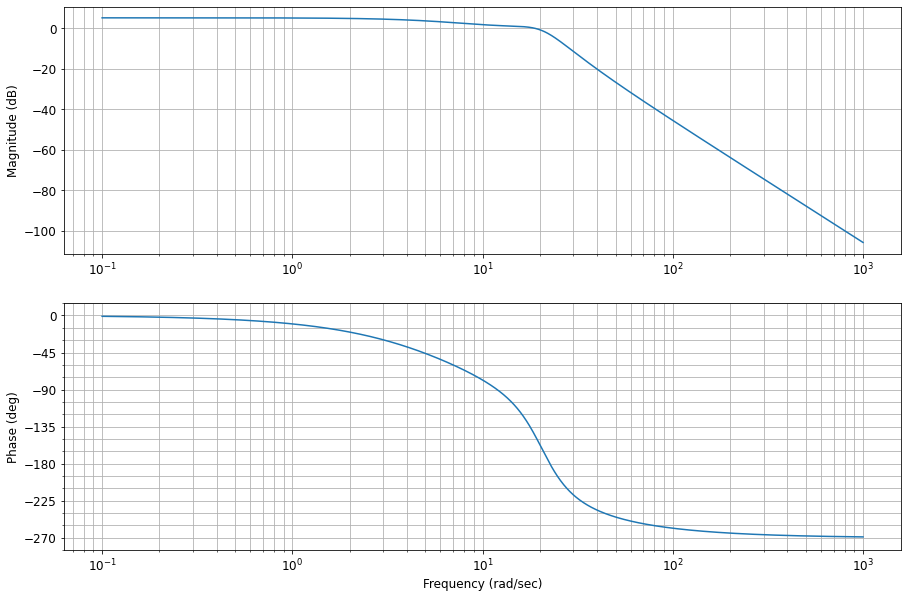

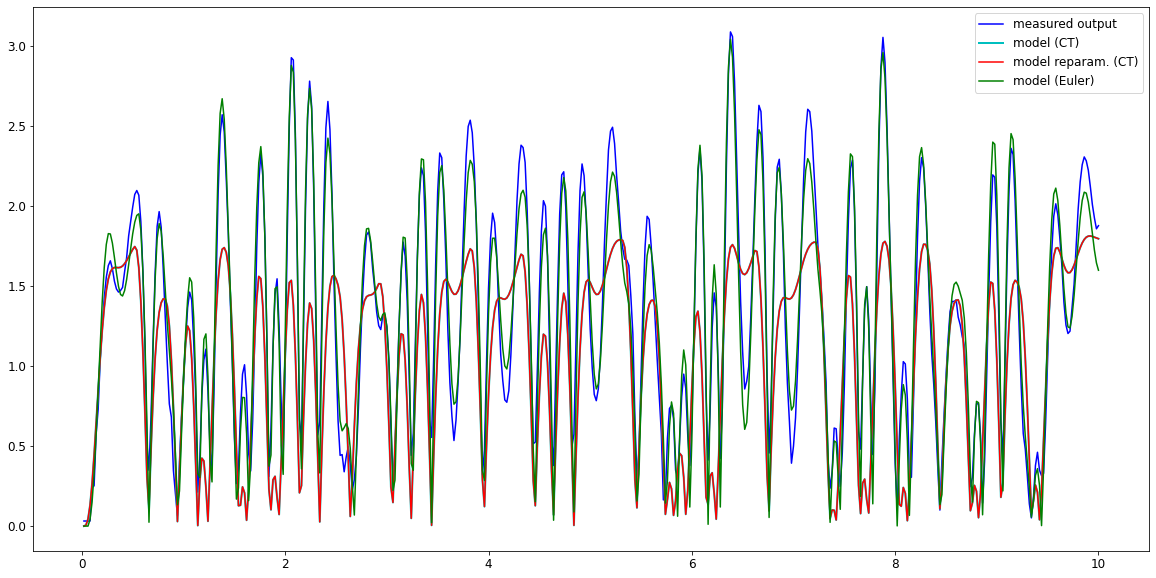

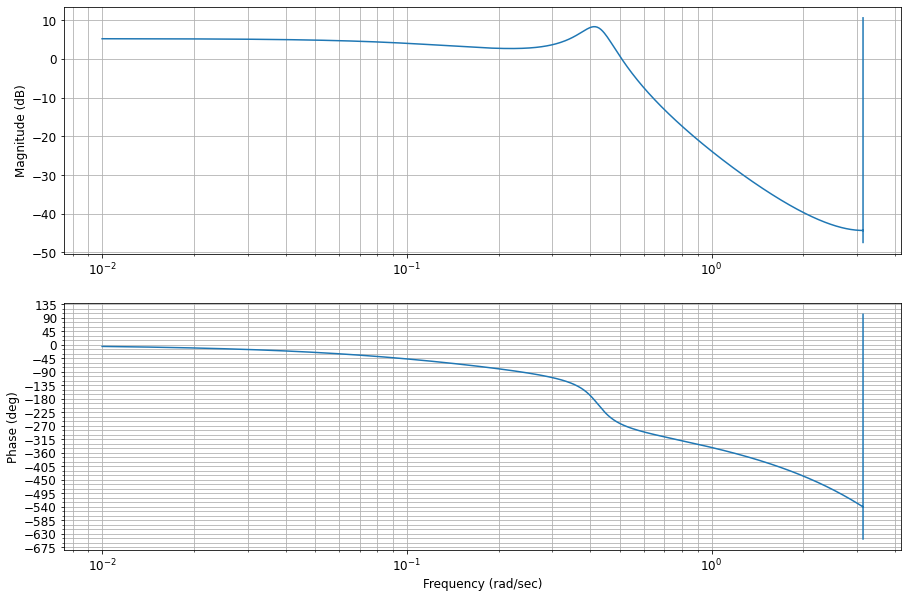


K:1.8212, alpha:6.7351, omega0:20.5166, xi:0.3216


In [16]:
_, _, _, _, _ = get_true_params(**dataset_prbs1, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=True) # Dataset-1

In [17]:
print("Dataset-1")
k_1, alpha_1, omega0_1, xi_1, y1_model_euler = get_true_params(**dataset_prbs1, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=False) # Dataset-1

Dataset-1

K:1.8212, alpha:6.7351, omega0:20.5166, xi:0.3216


In [18]:
k_2, alpha_2, omega0_2, xi_2, y2_model_euler = get_true_params(**dataset_prbs2, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=False) # Dataset-2


K:1.9174, alpha:5.2777, omega0:19.9190, xi:0.3183


In [19]:
k_3, alpha_3, omega0_3, xi_3, y3_model_euler = get_true_params(**dataset_prbs3, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=False) # Dataset-3


K:1.8264, alpha:6.5628, omega0:20.4591, xi:0.3189


In [20]:
k_4, alpha_4, omega0_4, xi_4, y4_model_euler = get_true_params(**dataset_prbs4, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=False) # Dataset-4


K:1.7653, alpha:7.0161, omega0:20.4391, xi:0.3303


In [21]:
k_5, alpha_5, omega0_5, xi_5, y5_model_euler = get_true_params(**dataset_prbs5, Ts=Ts, u=u1, y=z1, t_arr=t_arr, plot_curves=False) # Dataset-5, Pretty odd set of values


K:1.6014, alpha:64.9181, omega0:15.8116, xi:0.7078


## Generate the evaluation dataset

In [22]:
# Set parameters for training data generation
N=500
M=1
P=1

In [23]:
e_k_std = 1e-6
theta_vector_true = np.array([k_1, alpha_1, omega0_1, xi_1, e_k_std])

In [24]:
#Z_pM_test_fixed_theta = generate_trajectory(N=N, 
#                                            u=u1, 
#                                            Ts=Ts, 
#                                            theta_vector=theta_vector_true, 
#                                            add_noise_flag=False)

In [25]:
Z_pM_test_fixed_theta = z1

In [26]:
Z_pM_test_fixed_theta.shape

(500, 1)

In [27]:
Z_pM_test_fixed_theta = np.expand_dims(Z_pM_test_fixed_theta, axis=0)
theta_vector_true = theta_vector_true.reshape((-1, 1))
theta_vector_true = np.expand_dims(theta_vector_true, axis=0)
print(Z_pM_test_fixed_theta.shape, theta_vector_true.shape)

(1, 500, 1) (1, 5, 1)


In [28]:
# Importing the model configuration options
with open("../config/configurations_alltheta_ce_drive_prbs.json") as f:
    options = json.load(f)

In [29]:
# Prediction using trained model
def compute_loss_using_saved_model(actual_data, actual_theta_vectors, best_saved_model, model_type, device, criterion=None, mask=None):
    te_running_loss = 0.0
    test_loss_epoch_sum = 0.0
    mask = mask.flatten()
    #mask = [True, True, False, False, True, True, True]
    with torch.no_grad():

        # using batch gradient descent
        #for i in range(len(Z_pM_test["data"])):
        #theta_vector = Z_pM_test["data"][:, 0]
        #print("Actual set of parameters for {}-th example \n {}".format(i+1, theta_vector.T))
        #actual_data = np.expand_dims(Z_pM_test["data"][:][1], axis=0)
        X_test = Variable(torch.from_numpy(actual_data), requires_grad=False).type(torch.FloatTensor).to("cpu")
        prediction_theta_vectors = best_saved_model.forward(X_test)
        print(prediction_theta_vectors.shape)
        #print("Actual set of parameters for sample example \n {}".format(actual_theta_vectors))
        #print("Prediction set of parameters for the example \n {}".format(prediction_theta_vector.numpy()))
        loss = criterion(prediction_theta_vectors[mask, :], torch.from_numpy(actual_theta_vectors.squeeze(2)[mask, :]))
        print("Loss for saved {} model is : {}".format(model_type, loss))
        print("-"*100)
    
    return loss, prediction_theta_vectors

In [30]:
# Define a function for loading model
def load_model_from_weights(model_type, model_file, device):
    #Load and Set model in evaluation mode
    model = RNN_model(**options[model_type]).to(device)
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    model = push_model(nets=model, device=device)
    model.eval()
    return model

In [31]:
def evaluate_using_saved_RNN_model(Z_pM_test, actual_theta_vectors, best_saved_model_file, model_type='gru', device='cpu', criterion=None, mask=None):
    
    # Define some criterion for evaluation if not specified already
    if criterion is None:
        criterion = nn.MSELoss(reduction='mean')
    
    # Load the saved model
    best_saved_model = load_model_from_weights(model_type, 
                                                   best_saved_model_file, 
                                                   device)
    
    # Print some shapes for sanity check
    # Print out some shapes for sanity check
    #print(Z_pM_test_sampled_theta["data"][0][1].shape, 
    #      type(Z_pM_test_sampled_theta["data"][0][1]), 
    #      Z_pM_test_sampled_theta["data"][0][0].shape)
    
    # Get the data and targets separately as a numpy array
    actual_data = Z_pM_test
    #actual_theta_vectors = np.row_stack([np.expand_dims(Z_pM_test["data"][i][0], axis=0) for i in range(len(Z_pM_test["data"]))])
    
    # Print shape of inputs and targets
    print("Input shape:{}, Targets shape:{}".format(actual_data.shape, actual_theta_vectors.shape))
    
    # Get loss, predictions
    loss, predicted_theta_vectors = compute_loss_using_saved_model(actual_data, 
                                                                   actual_theta_vectors, 
                                                                   best_saved_model, 
                                                                   model_type, 
                                                                   device,
                                                                   criterion,
                                                                   mask=mask)
    
    return loss, predicted_theta_vectors

In [32]:
'''
best_model_gru_model = 'models/ce_drive/prbs/gru_L2_H60_results/gru_usenorm_0_ckpt_epoch_2864_best.pt'
trained_gru_model = 'models/ce_drive/prbs/gru_L2_H60_results/gru_usenorm_0_ckpt_epoch_3000.pt'
default_mask = np.array([True]*len(Z_pM_test_fixed_theta))

print("Evaluate for model:{}".format(best_model_gru_model))
gru_best_model_loss, gru_best_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             actual_theta_vectors=theta_vector_true,
                                                                                             best_saved_model_file=best_model_gru_model,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)


print("Evaluate for model:{}".format(trained_gru_model))
gru_model_loss, gru_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                   actual_theta_vectors=theta_vector_true,
                                                                                 best_saved_model_file=trained_gru_model,
                                                                                 model_type='gru',
                                                                                 device='cpu',
                                                                                 criterion=nn.MSELoss(reduction='mean'),
                                                                                 mask=default_mask)
'''

'\nbest_model_gru_model = \'models/ce_drive/prbs/gru_L2_H60_results/gru_usenorm_0_ckpt_epoch_2864_best.pt\'\ntrained_gru_model = \'models/ce_drive/prbs/gru_L2_H60_results/gru_usenorm_0_ckpt_epoch_3000.pt\'\ndefault_mask = np.array([True]*len(Z_pM_test_fixed_theta))\n\nprint("Evaluate for model:{}".format(best_model_gru_model))\ngru_best_model_loss, gru_best_model_predicted_theta_vectors = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,\n                                                                                             actual_theta_vectors=theta_vector_true,\n                                                                                             best_saved_model_file=best_model_gru_model,\n                                                                                             model_type=\'gru\',\n                                                                                             device=\'cpu\',\n                                               

In [33]:
#best_model_gru_model_improved = '../models/ce_drive/prbs/gru_L2_H40_results_05122021_120004/gru_usenorm_0_ckpt_epoch_3979_best.pt'
best_model_gru_model_improved = '../models/ce_drive/prbs/gru_L2_H40_results_29122021_182711/gru_usenorm_0_ckpt_epoch_702_best.pt'
#best_model_gru_model_improved = '../models/ce_drive/prbs/gru_L2_H40_results_27122021_194312/gru_usenorm_0_ckpt_epoch_105_best.pt'
#trained_gru_model_improved = '../models/ce_drive/prbs/gru_L2_H40_results_16082021_223127/gru_usenorm_0_ckpt_epoch_3000.pt'
default_mask = np.array([True]*len(Z_pM_test_fixed_theta))

print("Evaluate for model:{}".format(best_model_gru_model_improved))
gru_best_model_loss_improved, gru_best_model_predicted_theta_vectors_improved = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             actual_theta_vectors=theta_vector_true,
                                                                                             best_saved_model_file=best_model_gru_model_improved,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)


#print("Evaluate for model:{}".format(trained_gru_model_improved))
#gru_model_loss_improved, gru_model_predicted_theta_vectors_improved = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
#                                                                                   actual_theta_vectors=theta_vector_true,
#                                                                                 best_saved_model_file=trained_gru_model_improved,
#                                                                                 model_type='gru',
#                                                                                 device='cpu',
#                                                                                 criterion=nn.MSELoss(reduction='mean'),
#                                                                                 mask=default_mask)

Evaluate for model:../models/ce_drive/prbs/gru_L2_H40_results_29122021_182711/gru_usenorm_0_ckpt_epoch_702_best.pt
Input shape:(1, 500, 1), Targets shape:(1, 5, 1)
torch.Size([1, 5])
Loss for saved gru model is : 0.1225997292292595
----------------------------------------------------------------------------------------------------


In [34]:
gru_best_model_predicted_theta_vectors_improved

tensor([[1.9800e+00, 5.9997e+00, 2.0457e+01, 1.1334e-01, 3.0480e-03]])

In [35]:
theta_vector_true

array([[[1.82116402e+00],
        [6.73506669e+00],
        [2.05166090e+01],
        [3.21567110e-01],
        [1.00000000e-06]]])

In [36]:
Hs

TransferFunction(array([5163.]), array([1.000e+00, 1.993e+01, 5.098e+02, 2.835e+03]))

In [37]:
Hs_model_improved = compute_actual_tf(k=gru_best_model_predicted_theta_vectors_improved[:,0],
                             alpha=gru_best_model_predicted_theta_vectors_improved[:,1],
                             omega0=gru_best_model_predicted_theta_vectors_improved[:,2],
                             xi=gru_best_model_predicted_theta_vectors_improved[:,3])
Hs_model_improved

TransferFunction(array([4971.31347656]), array([1.00000000e+00, 1.06369905e+01, 4.46296838e+02, 2.51071225e+03]))

In [38]:
#e_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(gru_best_model_predicted_theta_vectors[:,4]))
model_zoh_gru_c2d = c2d(sysc=Hs_model_improved, Ts=Ts, method='zoh') # Discretized version of CT model
y_model_gru_continuous_time = np.abs(lsim(Hs_model_improved, U=u1.reshape((-1,)), T=t_arr)[0])

# def cost_function(parameters):
    # my_model is a continuous time transfer function, simulate_model also simulates in continuous time,
    # Parameters are unconstrained, no nose considered
    # Idea: How good can this model structure ? 
    # Input signal and Output signal are from original dataset
    # Model_output = simulate_model(my_model(parameters), input_signal)
    # J = cost(Model_output, output_signal) where J = MSELoss()
    # minimize the cost 

flag = isstable(np.array(ct.pole(model_zoh_gru_c2d)), 
            sys_type='discrete')

assert flag == True, "System is not stable!"

y_model_zoh_gru_c2d = simulate_model(Gs=model_zoh_gru_c2d, u=u1.reshape((-1,))).reshape((-1, 1)) # Output of Discretized model
y_model_gru = y_model_zoh_gru_c2d #+ e_k_arr # Add the measurement noise, abs() already done for simulate_model

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/control/timeresp.py:293: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


## Get estimates using CME-MH algorithm

In [39]:
Hs_model_MH = compute_actual_tf(k=1.9934, alpha=5.7966, omega0=20.1451, xi=0.1156)
#e_k_arr = generate_normal(N=N, mean=0, std=np.sqrt(gru_best_model_predicted_theta_vectors[:,4]))
model_zoh_MH_c2d = c2d(sysc=Hs_model_MH, Ts=Ts, method='zoh') # Discretized version of CT model
y_model_MH_continuous_time = np.abs(lsim(Hs_model_MH, U=u1.reshape((-1,)), T=t_arr)[0])

# def cost_function(parameters):
    # my_model is a continuous time transfer function, simulate_model also simulates in continuous time,
    # Parameters are unconstrained, no nose considered
    # Idea: How good can this model structure ? 
    # Input signal and Output signal are from original dataset
    # Model_output = simulate_model(my_model(parameters), input_signal)
    # J = cost(Model_output, output_signal) where J = MSELoss()
    # minimize the cost 

flag_MH = isstable(np.array(ct.pole(model_zoh_MH_c2d)), 
            sys_type='discrete')

assert flag == True, "System is not stable!"

y_model_zoh_MH_c2d = simulate_model(Gs=model_zoh_MH_c2d, u=u1.reshape((-1,))).reshape((-1, 1)) # Output of Discretized model
y_model_MH = y_model_zoh_MH_c2d #+ e_k_arr # Add the measurement noise, abs() already done for simulate_model

## Plotting the results

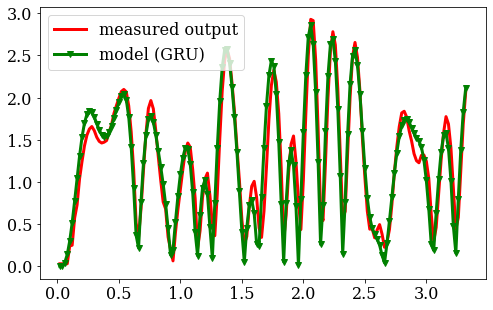

In [40]:
plt.figure(figsize=(8,5))
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 16})
l = len(t_arr) // 3
#plt.subplot(2,1,1)
plt.plot(t_arr[:l], z1[:l], 'r', label='measured output', linewidth=3)
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
#plt.plot(t_arr[:l], y_model[:l],'b--', label='model (CT)', linewidth=2)
#plt.plot(t_arr, y_model_gru_continuous_time, 'k', label='model (GRU continuous)')
#plt.plot(t_arr, y_model_gru,'g', label='model (GRU discretized)')
plt.plot(t_arr[:l], y_model_gru[:l], 'gv-', label='model (GRU)', linewidth=3)
plt.legend()
#plt.savefig('./Results_ce_drive_prbs_GRU_short_M1000_P500_Lr_0.0005_p2.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


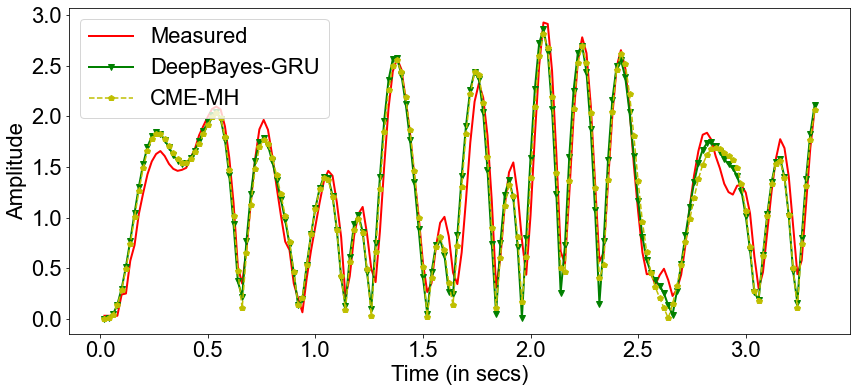

In [48]:
plt.figure(figsize=(14,6))
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 22})
l = len(t_arr) // 3
#plt.subplot(2,1,1)
plt.plot(t_arr[:l], z1[:l], 'r', label='Measured', linewidth=2)
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
#plt.plot(t_arr[:l], y_model[:l],'b--', label='model (CT)', linewidth=2)
#plt.plot(t_arr, y_model_gru_continuous_time, 'k', label='model (GRU continuous)')
#plt.plot(t_arr, y_model_gru,'g', label='model (GRU discretized)')
plt.plot(t_arr[:l], y_model_gru[:l], 'gv-', label='DeepBayes-GRU', linewidth=2)
plt.plot(t_arr[:l], y_model_MH[:l], 'yp--', label='CME-MH', linewidth=1.5)
plt.xlabel('Time (in secs)')
plt.ylabel('Amplitude')
plt.legend(fontsize=22)
plt.savefig('./Results_ce_drive_prbs_GRU_MH_short_M1000_P500_Lr_0.0005_p3.eps')
plt.show()

In [40]:
(z1 - y_model_gru.reshape((-1, 1))).shape

(500, 1)

In [41]:
print(np.mean(z1 - y_model_gru.reshape((-1, 1))))

0.013931250691008755


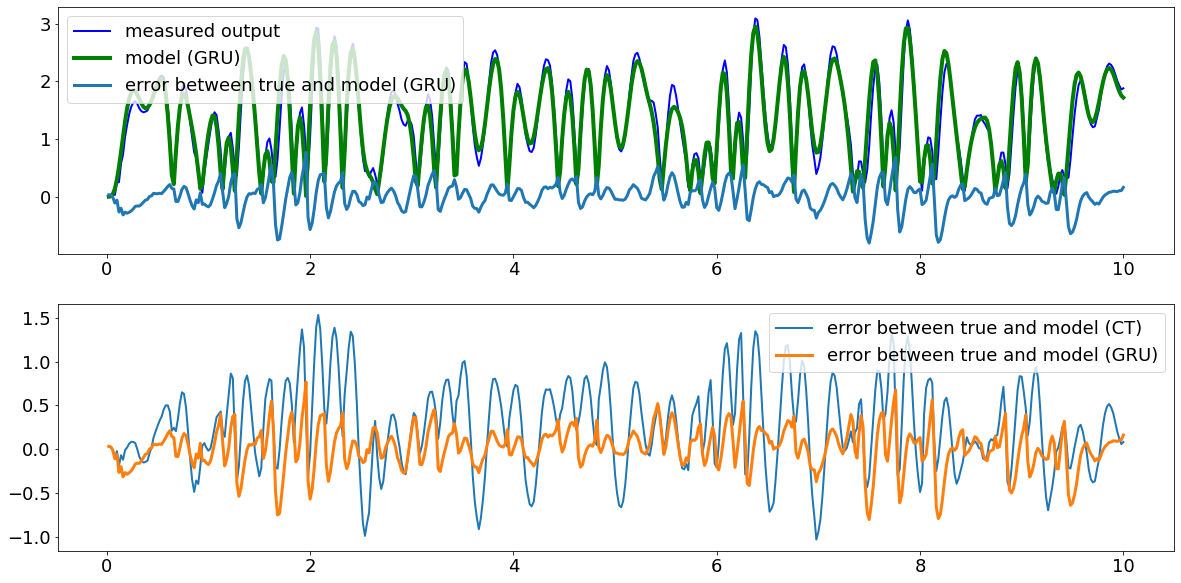

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
plt.subplot(211)
#plt.subplot(2,1,1)
plt.plot(t_arr, z1, 'b-', label='measured output', linewidth=2)
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
#plt.plot(t_arr, y_model,'r-', label='model (CT)', linewidth=2)
#plt.plot(t_arr, y_model_gru_continuous_time, 'k', label='model (GRU continuous)')
#plt.plot(t_arr, y_model_gru,'g', label='model (GRU discretized)')
plt.plot(t_arr, y_model_gru, 'g', label='model (GRU)', linewidth=4)
plt.plot(t_arr, z1 - y_model_gru.reshape((-1, 1)),  label='error between true and model (GRU)', linewidth=3)
plt.legend()
#plt.savefig('./first_results_ce_drive_prbs_gru_improved.pdf')

plt.subplot(212)
plt.plot(t_arr, z1 - y_model.reshape((-1, 1)), label='error between true and model (CT)', linewidth=2)
plt.plot(t_arr, z1 - y_model_gru.reshape((-1, 1)),  label='error between true and model (GRU)', linewidth=3)
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
#plt.plot(t_arr, y_model,'r-', label='model (CT)', linewidth=2)
#plt.plot(t_arr, y_model_gru_continuous_time, 'k', label='model (GRU continuous)')
#plt.plot(t_arr, y_model_gru,'g', label='model (GRU discretized)')
#plt.plot(t_arr, y_model_gru, 'g', label='model (GRU)', linewidth=3)
plt.legend()
#plt.savefig('./error_curves_and_separate_plots.pdf')
plt.show()


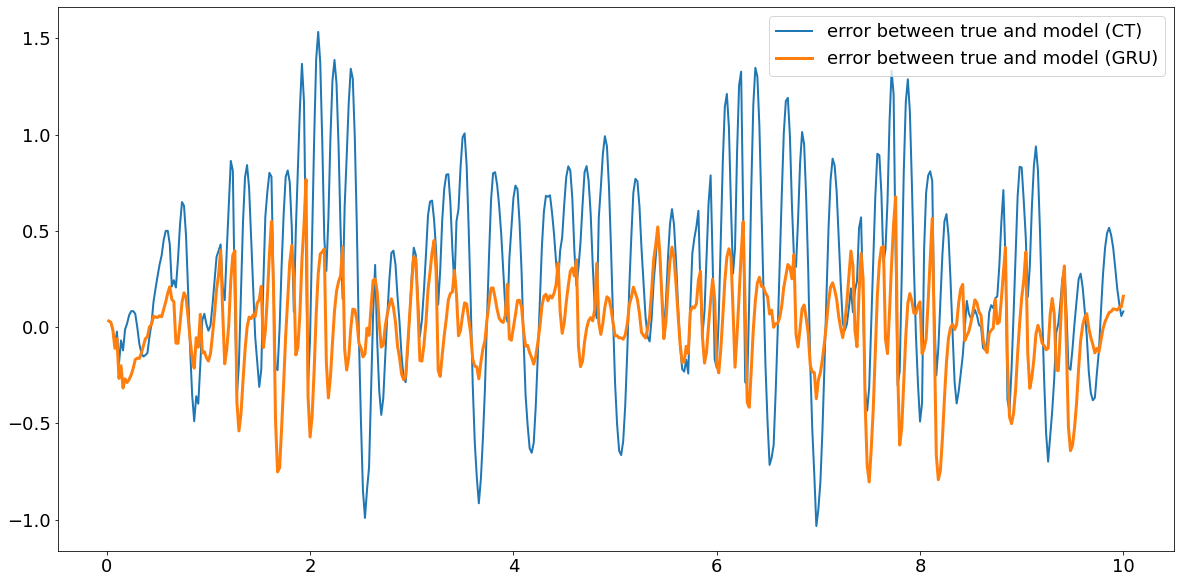

In [43]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
#plt.subplot(2,1,1)
plt.plot(t_arr, z1 - y_model.reshape((-1, 1)),  label='error between true and model (CT)', linewidth=2)
plt.plot(t_arr, z1 - y_model_gru.reshape((-1, 1)),  label='error between true and model (GRU)', linewidth=3)
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
#plt.plot(t_arr, y_model,'r-', label='model (CT)', linewidth=2)
#plt.plot(t_arr, y_model_gru_continuous_time, 'k', label='model (GRU continuous)')
#plt.plot(t_arr, y_model_gru,'g', label='model (GRU discretized)')
#plt.plot(t_arr, y_model_gru, 'g', label='model (GRU)', linewidth=3)
plt.legend()
#plt.savefig('./first_results_ce_drive_prbs_gru_improved.pdf')
plt.show()


In [44]:
z1.shape, y_model.shape

((500, 1), (500,))

In [45]:
import scipy.signal as sig

In [46]:
params_opt = {'a': 4236.801326482269,
 'b': -10.077737123551822,
 'c': -410.17564836697886,
 'd': -2059.5883325741747}

Hs_opt = sig.TransferFunction(params_opt["a"], [1, -params_opt["b"], -params_opt["c"], -params_opt["d"]])
y_model_brute_force_optim = np.abs(sig.lsim2(Hs_opt, u1.reshape((-1, 1)), t_arr)[1])

In [47]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

#x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
#y = np.array([[2,2], [3,3], [4,4]])
#distance, path = fastdtw(x, y, dist=euclidean)
#print(distance)

In [48]:
MSE_before_optimization = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model.reshape((-1, 1)))**2
MSE_after_optimization = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model_brute_force_optim.reshape((-1, 1)))**2
MSE_for_Euler_method = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model_euler.reshape((-1, 1)))**2
MSE_for_GRU_model = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model_gru.reshape((-1, 1)))**2

print("L2 norm values:")
print("Before optimization: {}".format(MSE_before_optimization))
print("For Euler method: {}".format(MSE_for_Euler_method))
print("After brute force optimization: {}".format(MSE_after_optimization))
print("Using GRU model: {}".format(MSE_for_GRU_model))

L2 norm values:
Before optimization: 154.8419463147349
For Euler method: 13.660232496366131
After brute force optimization: 38.84440672154143
Using GRU model: 27.873404183580856


In [49]:
DTW_distance_before_optimization, _ = fastdtw(z1.reshape((-1, 1)), y_model.reshape((-1, 1)), dist=None)
DTW_distance_after_optimization, _ = fastdtw(z1.reshape((-1, 1)), y_model_brute_force_optim.reshape((-1, 1)), dist=None)
DTW_distance_Euler_method, _ = fastdtw(z1.reshape((-1, 1)), y_model_euler.reshape((-1, 1)), dist=None)
DTW_distance_for_GRU_model, _ = fastdtw(z1.reshape((-1, 1)), y_model_gru.reshape((-1, 1)), dist=None)
print("DTW values (based on L1 norm distance):")
print("Before optimization: {}".format(DTW_distance_before_optimization))
print("For Euler method: {}".format(DTW_distance_Euler_method))
print("After brute force optimization: {}".format(DTW_distance_after_optimization))
print("Using GRU model: {}".format(DTW_distance_for_GRU_model))

DTW values (based on L1 norm distance):
Before optimization: 228.47507091343294
For Euler method: 56.75172633533445
After brute force optimization: 69.6019094996287
Using GRU model: 59.09394695188725
